In [1]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt
import seaborn as sns
import skimage
from skimage import measure, color, io
import scipy
import pandas as pd
from pandas import ExcelWriter
from sklearn.cluster import KMeans
import yaml
import json

#Helper Functions
def bgr2rgb(img):
    new_img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    return new_img

def bgr2hsv(img):
    new_img = cv.cvtColor(img,cv.COLOR_BGR2HSV)
    return new_img

def hsv2bgr(img):
    new_img = cv.cvtColor(img,cv.COLOR_HSV2BGR)
    return new_img

def hsvMask(img,low_set,high_set):
    mask = cv.inRange(img,low_set,high_set)
    return mask

def rgb2bgr(img):
    new_img = cv.cvtColor(img,cv.COLOR_RGB2BGR)
    return new_img
    
def holeClose(img,kernel_mat,iter_num):
    new_image = cv.morphologyEx(img,cv.MORPH_OPEN,kernel_mat,iterations=iter_num)
    return new_image
 
def dilate(img,kernel_mat,iter_num):
    new_img = cv.dilate(img,kernel=kernel_mat,iterations=iter_num)
    return new_img

def distTrans(img,mask_size):
    dist = cv.distanceTransform(img,cv.DIST_L2,mask_size)
    return dist

def noiseCleanup(img,b_noise,g_noise,r_noise):
    b,g,r = cv.split(img)
    _,b_mask = cv.threshold(b,b_noise,255,cv.THRESH_TOZERO)
    _,g_mask = cv.threshold(g,g_noise,255,cv.THRESH_TOZERO)
    _,r_mask = cv.threshold(r,r_noise,255,cv.THRESH_TOZERO)
    b_new = cv.bitwise_and(b,b,mask=b_mask)
    g_new = cv.bitwise_and(g,g,mask=g_mask)
    r_new = cv.bitwise_and(r,r,mask=r_mask)
    new_img = cv.merge([b_new,g_new,r_new])
    return new_img

def IoU(img_1,img_2):
    intersection = cv.bitwise_and(img_1,img_2)
    union = cv.bitwise_or(img_1,img_2)
    inter_area = np.sum(intersection==255)
    union_area = np.sum(union==255)
    return inter_area/union_area


with open('parameters.yaml', 'r') as file:
    parameters = yaml.safe_load(file)
    
img_path = "/home/devesh/cell-segmentation/images/15.tif"
img = cv.imread(img_path)

b_thres,g_thres,r_thres = parameters["Noise BGR Thresh"]

clean_img = noiseCleanup(img,b_thres,g_thres,r_thres)

low_green = np.array(parameters["Low Green HSV"])
high_green = np.array(parameters["High Green HSV"])

low_blue = np.array(parameters["Low Blue HSV"])
high_blue = np.array(parameters["High Blue HSV"])

low_red = np.array(parameters["Low Red HSV"])
high_red = np.array(parameters["High Red HSV"])

img_hsv = bgr2hsv(clean_img)

blue_mask = hsvMask(img_hsv,low_blue,high_blue)
green_mask = hsvMask(img_hsv,low_green,high_green)
red_mask = hsvMask(img_hsv,low_red,high_red)

full_mask = cv.bitwise_or(green_mask,blue_mask,red_mask)

kernel_matrix = np.ones((5,5),np.uint8)
d_iterations = parameters["Image Dilation Iter"]
dilated = dilate(full_mask,kernel_matrix,d_iterations)
dilated_b = dilate(blue_mask,kernel_matrix,d_iterations)
dilated_g = dilate(green_mask,kernel_matrix,d_iterations)
dilated_r = dilate(red_mask,kernel_matrix,d_iterations)

kernel_matrix = np.ones((7,7),np.uint8)
h_iterations =  parameters["Hole Closing Iter"]
holeClosed = holeClose(dilated,kernel_matrix,h_iterations)
holeClosed_b = holeClose(dilated_b,kernel_matrix,h_iterations)
holeClosed_g = holeClose(dilated_g,kernel_matrix,h_iterations)
holeClosed_r = holeClose(dilated_r,kernel_matrix,h_iterations)

IoU_bg = IoU(holeClosed_b,holeClosed_g)
IoU_br = IoU(holeClosed_b,holeClosed_r)
IoU_rg = IoU(holeClosed_r,holeClosed_g)
IoUs = pd.DataFrame({'IoU_bg':IoU_bg,'IoU_br':IoU_br,'IoU_rg':IoU_rg},index=[0])

mask_size = parameters["Distance Transform Mask Size"]
dist = distTrans(holeClosed,mask_size)

max_size = parameters["Distance Thresholding Max Size"]
_,sure_fg = cv.threshold(dist,max_size*dist.max(),255,0)

propList = ['Area','intensity_mean','intensity_max','intensity_min','centroid_local','slice']

sure_fg = cv.convertScaleAbs(sure_fg)
etc,markers = cv.connectedComponents(sure_fg)
markers = markers+10
watershed = cv.watershed(img,markers)
img[markers == -1] = [0,255,255]
img_res = color.label2rgb(markers, bg_label=0)
regions = measure.regionprops_table(markers, intensity_image=img,properties=propList)
regions = pd.DataFrame(regions)
#regions = regions.drop(columns=["intensity_mean-2","intensity_max-2","intensity_min-2"])

intensities = regions.iloc[:,1:4]
pc_intensities = pd.DataFrame(intensities.corr(method="pearson"))

b,g,r = cv.split(clean_img)
b = b.flatten()
g = g.flatten()
r = r.flatten()
tot_img = pd.DataFrame({'blue':b,'green':g,'red':r})
pc_raw = pd.DataFrame(tot_img.corr(method="pearson"))

optimal_k_val = parameters["Optimal K"]
kmeans = KMeans(n_clusters=optimal_k_val).fit(intensities)
centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(centroids)


In [14]:
index = clean_img[:,:,0] <30
np.where(clean_img[:,:,0]<30)[0].shape

(2840163,)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

2840163

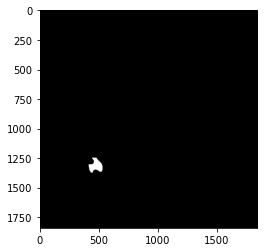

In [11]:
plt.imshow(individual_masks[30],cmap="gray")

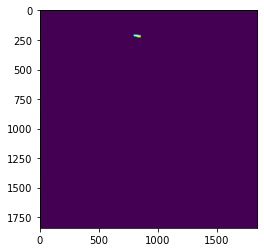